# Crypto API automatic scraping 

### Scraping functions

The purpose of this project is to obtain the crypto data from the coinmarketcap API in order to have a better view of the crypto market and automatize the process.


In [1]:
#import request libraries for API and json library for extraction
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json


In [2]:
#import pandas library for dataframes
import pandas as pd
#show all the columns 
pd.set_option('display.max_columns', None)
pd.options.display.max_rows=15

In [3]:
#libraries for automatic extraction
import os 
from time import time 
from time import sleep 

The first step is to extract the data from the website, in order to that we define the function api_extract. 
This function "api_extract" extract crypto data from the coinmarketcap API, normalize the json data and add a column to the data frame with the daytime of extraction. In fact, could be useful to add a new column where we can store the daytime of the operation with the timestamp method in order to track when the updates have been done. We'll use the method Timestamp to do that.
Then it will return a dataframe that will be stored in a dataframe object.


In [4]:
#definition of our Api_key taken by our coinmakercap profile
Api_key='********-****-****-****-************'
#definition of the number of crypto extracted
limit='400'

In [5]:
def api_extract():  
  url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
  parameters = {
    'start':'1',
    'limit':limit,
    'convert':'USD'
  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': Api_key,
  }

  session = Session()
  session.headers.update(headers)

  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    #print(data)
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
  #Normalize data using the json_normalize method
  df=pd.json_normalize(data['data'])
  #Create a new column with the current hour using the timestamp method
  df['timestamp']=pd.Timestamp('now')
  return df


The function "api_append_data" adds to our original dataframe created with the "api_extract" another extraction in order to have different data for our dataframe. It stores new data in another dataframe (df2) and then adds it to the global df dataframe with the concat pandas funtion.

In [6]:
def api_append_data():

  global df
  url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
  parameters = {
    'start':'1',
    'limit': limit,
    'convert':'USD'
  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': Api_key,
  }

  session = Session()
  session.headers.update(headers)

  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    #print(data)
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
  #Normalize data using the json_normalize method
  df2=pd.json_normalize(data['data'])
  #Create a new column with the current hour using the timestamp method
  df2['timestamp']=pd.Timestamp('now')
  #Merge the dataframe just extracted with our original dataframe to add our new updated data using the method concat
  df=pd.concat([df, df2], ignore_index=True)

With the next function "csv_extract" we can store a new data extraction in a csv file. This function will add a new extraction to our csv file called "cryptodata.csv" with the append mode. If it doesn't exist (first extraction) it will create a new csv.

In [7]:
def csv_extract():
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    parameters = {
    'start':'1',
    'limit': limit,
    'convert':'USD'
    }
    headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': Api_key,
    }

    session = Session()
    session.headers.update(headers)

    try:
        response = session.get(url, params=parameters)
        data = json.loads(response.text)
        #print(data)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    #Normalize data using the json_normalize method
    df=pd.json_normalize(data['data'])
    #Create a new column with the current hour using the timestamp method
    df['timestamp']=pd.Timestamp('now')
    #check if the csv already exist, if not create a new one
    if not os.path.isfile('cryptodata.csv'):
        df.to_csv('cryptodata.csv', index=False)
    else:
        #else add the data to the dataframe with the append mode 
        df.to_csv('cryptodata.csv', mode='a', index=False, header=False) 

It could be also useful create a function to add to the csv all the data just extracted with the other functions

In [8]:
def add_extractions_to_csv():
    
    if not os.path.isfile('cryptodata.csv'):
        df.to_csv('cryptodata.csv', index=False)
    else:
        #else add the data to the dataframe with the mode append
        df.to_csv('cryptodata.csv', mode='a', index=False, header=False)

Then we can creare a function to run periodically our api_append_data in order to store crypto data at different moment.
To do that, inside the for cycle, we'll use the sleep function that will wait to finish the cycle the amount of second we desire and run another cycle. Since we have the free plan we can only run the program a limited number of times. We have 333 credit per each day (this explain the 333 in the range of the for cycle) and each extraction will use a certain number of credits (1 credit for 200 crypto extract). For example our extraction (with 5000 crypto data) will use 25 credits per run. So we set this amount our limit divided by 200 as defalut parameter. We also set 60 seconds (1 minute) as default sleeptime. We can also set the number of extraction we want to avoid to finish our credits.

In [9]:
def automatic_data_extraction(sleeptime=600, credits_required=int(float(limit)/(200)), extractions=0):
    #define the maximun number of extraction available for out limit
    maximum_extractions=int(333/credits_required)
    # if we don't set the number of extraction or we set a value not acceptable or bigger than the number of extractions
    if extractions<=0:
        for i in range(0, maximum_extractions):
            api_append_data()
            print('Api successfully extracted: {}'.format(i+1))
            sleep(sleeptime)
        print('Maximum extractions reached today')
        exit()
    #else we run the exact number of extractions
    else:
        for i in range(0, extractions):
            api_append_data()
            sleep(sleeptime)
            print('Api successfully extracted: {}'.format(i+1))
        

First of all we'll run our function api_extract to extract our data for the first time and store it in a pandas dataframe

In [ ]:
df=api_extract()

Now, if we want to add other crypto data extractions we can run the function api_append_data() defining the sleeptime between extraction and optionally the number of extraction (if we don't want to extract the maximum number of daily extraction) and the credite usage (if different from our formula for some reason)

In [ ]:
automatic_data_extraction(sleeptime=6, extractions=1)

Now we can run a new extraction and store it in our csv crypto data to save data.

In [ ]:
csv_extract()

We could also store our dataframe with all the extraction we made in our csv crypto data.

In [ ]:
add_extractions_to_csv()



### Data cleaning and analysis

In [10]:
#Libraries for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

After the collection of the data we can analyze them. In order to do that, we'll take all the past data collected in our csv during the last estraction.

In [11]:
df=pd.read_csv('cryptodata.csv', sep=',')
df

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
0,1,Bitcoin,BTC,bitcoin,9984,2013-04-28,"['mineable', 'pow', 'sha-256', 'store-of-value...",2.100000e+07,1.929486e+07,1.929486e+07,NaN,1,NaN,NaN,NaN,2023-02-18T14:17:00.000Z,24569.830560,3.521667e+10,-9.1310,-0.167629,3.114198,12.901593,18.410465,46.201007,48.267850,4.740713e+11,42.4991,5.159664e+11,NaN,2023-02-18T14:17:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-18 15:19:48.143871
1,1027,Ethereum,ETH,ethereum,6471,2015-08-07,"['pos', 'smart-contracts', 'ethereum-ecosystem...",NaN,1.223739e+08,1.223739e+08,NaN,2,NaN,NaN,NaN,2023-02-18T14:17:00.000Z,1695.484591,8.382107e+09,-25.0315,-0.119527,1.874955,11.281625,11.351600,40.098274,44.072832,2.074830e+11,18.6001,2.074830e+11,NaN,2023-02-18T14:17:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-18 15:19:48.143871
2,825,Tether,USDT,tether,47766,2015-02-25,"['payments', 'stablecoin', 'asset-backed-stabl...",NaN,7.029394e+10,7.314177e+10,NaN,3,NaN,NaN,NaN,2023-02-18T14:17:00.000Z,1.000272,4.716492e+10,-13.3405,0.000059,0.013589,0.004490,0.029483,0.013653,0.128137,7.031304e+10,6.3034,7.316164e+10,NaN,2023-02-18T14:17:00.000Z,1027.0,Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-02-18 15:19:48.143871
3,1839,BNB,BNB,bnb,1192,2017-07-25,"['marketplace', 'centralized-exchange', 'payme...",2.000000e+08,1.578976e+08,1.599800e+08,NaN,4,NaN,NaN,NaN,2023-02-18T14:17:00.000Z,316.729008,6.381177e+08,-21.9208,0.031392,2.368470,2.352801,9.857606,27.121858,17.524616,5.001077e+10,4.4834,6.334580e+10,NaN,2023-02-18T14:17:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-18 15:19:48.143871
4,3408,USD Coin,USDC,usd-coin,10163,2018-10-08,"['medium-of-exchange', 'stablecoin', 'asset-ba...",NaN,4.184109e+10,4.184109e+10,NaN,5,NaN,NaN,NaN,2023-02-18T14:17:00.000Z,0.999968,3.955267e+09,-21.8437,-0.008109,-0.006305,-0.022753,-0.002628,-0.000764,-0.027679,4.183977e+10,3.7508,4.183977e+10,NaN,2023-02-18T14:17:00.000Z,1027.0,Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-02-18 15:19:48.143871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4039,ARPA,ARPA,arpa-chain,94,2019-07-15T00:00:00.000Z,"['scaling', 'arrington-xrp-capital-portfolio']",2.000000e+09,1.242889e+09,1.500000e+09,NaN,396,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,0.047313,2.563883e+07,-47.2475,-0.916369,-2.051487,8.588934,29.586145,79.339736,74.897410,5.880513e+07,0.0054,9.462654e+07,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xba50933c268f567bdc86e1ac131be072c6b0b71a,2023-02-23 17:50:59.559045
1996,10223,Vega Protocol,VEGA,vegaprotocol,27,2021-09-02T19:00:00.000Z,"['pos', 'defi', 'derivatives', 'coinbase-ventu...",6.499972e+07,4.293596e+07,6.499972e+07,NaN,397,4.293596e+07,5.867231e+07,NaN,2023-02-23T16:48:00.000Z,1.366507,6.611062e+05,10.9523,-0.174419,10.068258,7.790287,11.184018,76.041325,27.709312,5.867231e+07,0.0054,8.882260e+07,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xcb84d72e61e383767c4dfeb2d8ff7f4fb89abc6e,2023-02-23 17:50:59.559045
1997,11206,Bloktopia,BLOK,bloktopia,48,2021-08-09T00:00:00.000Z,"['metaverse', 'polkafoundry-red-kite', 'bullpe...",1.998684e+11,1.753664e+10,2.000000e+11,NaN,398,1.305261e+10,4.366860e+07,NaN,2023-02-23T16:48:00.000Z,0.003346,1.750819e+06,13.3141,-0.048442,0.485266,-14.018700,25.781970,74.631029,58.601426,5.867031e+07,0.0054,6.6867

In order to have a better visualization we can remove the time from the column "date_added" since we don't need the time in this column

In [12]:
df['date_added']=df['date_added'].str[:10]

Then with the unique method we can check the data-time of every estraction

In [13]:
df["timestamp"].unique()

array(['2023-02-18 15:19:48.143871', '2023-02-20 21:00:05.084674',
       '2023-02-21 20:32:02.076175', '2023-02-22 16:36:37.355943',
       '2023-02-23 17:50:59.559045'], dtype=object)

To analyze the most recent crypto data we'll take last extraction by timestamp

In [14]:
df_last_extr=df[df["timestamp"]==df["timestamp"].max()]
df_last_extr

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
1600,1,Bitcoin,BTC,bitcoin,9989,2013-04-28,"['mineable', 'pow', 'sha-256', 'store-of-value...",2.100000e+07,1.929988e+07,1.929988e+07,NaN,1,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,23906.499740,3.098458e+10,1.5592,-0.353210,0.779230,-3.944550,4.387160,42.195965,44.694247,4.613925e+11,42.1948,5.020365e+11,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1601,1027,Ethereum,ETH,ethereum,6496,2015-08-07,"['pos', 'smart-contracts', 'ethereum-ecosystem...",NaN,1.223739e+08,1.223739e+08,NaN,2,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,1653.094766,9.468341e+09,7.7620,-0.269281,2.651850,-3.714540,2.159197,36.412390,38.560043,2.022956e+11,18.5023,2.022956e+11,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1602,825,Tether,USDT,tether,48170,2015-02-25,"['payments', 'stablecoin', 'asset-backed-stabl...",NaN,7.059060e+10,7.314177e+10,NaN,3,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,1.000122,4.232340e+10,-3.6897,-0.002726,-0.003203,-0.007754,0.001383,0.020734,0.059079,7.059920e+10,6.4572,7.315068e+10,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-02-23 17:50:59.559045
1603,1839,BNB,BNB,bnb,1195,2017-07-25,"['marketplace', 'centralized-exchange', 'payme...",NaN,1.578965e+08,1.599800e+08,NaN,4,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,308.577913,4.702523e+08,-15.3603,-0.329072,1.250714,-4.293285,-1.895752,26.810411,2.304878,4.872337e+10,4.4558,4.936628e+10,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1604,3408,USD Coin,USDC,usd-coin,10293,2018-10-08,"['medium-of-exchange', 'stablecoin', 'asset-ba...",NaN,4.225271e+10,4.225271e+10,NaN,5,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,0.999937,4.225057e+09,-4.0436,0.001962,-0.001484,-0.010487,0.008693,-0.025499,-0.010259,4.225007e+10,3.8640,4.225007e+10,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-02-23 17:50:59.559045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4039,ARPA,ARPA,arpa-chain,94,2019-07-15,"['scaling', 'arrington-xrp-capital-portfolio']",2.000000e+09,1.242889e+09,1.500000e+09,NaN,396,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,0.047313,2.563883e+07,-47.2475,-0.916369,-2.051487,8.588934,29.586145,79.339736,74.897410,5.880513e+07,0.0054,9.462654e+07,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xba50933c268f567bdc86e1ac131be072c6b0b71a,2023-02-23 17:50:59.559045
1996,10223,Vega Protocol,VEGA,vegaprotocol,27,2021-09-02,"['pos', 'defi', 'derivatives', 'coinbase-ventu...",6.499972e+07,4.293596e+07,6.499972e+07,NaN,397,4.293596e+07,5.867231e+07,NaN,2023-02-23T16:48:00.000Z,1.366507,6.611062e+05,10.9523,-0.174419,10.068258,7.790287,11.184018,76.041325,27.709312,5.867231e+07,0.0054,8.882260e+07,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xcb84d72e61e383767c4dfeb2d8ff7f4fb89abc6e,2023-02-23 17:50:59.559045
1997,11206,Bloktopia,BLOK,bloktopia,48,2021-08-09,"['metaverse', 'polkafoundry-red-kite', 'bullpe...",1.998684e+11,1.753664e+10,2.000000e+11,NaN,398,1.305261e+10,4.366860e+07,NaN,2023-02-23T16:48:00.000Z,0.003346,1.750819e+06,13.3141,-0.048442,0.485266,-14.018700,25.781970,74.631029,58.601426,5.867031e+07,0.0054,6.686765e+08,NaN,2023-02-23T16:48:00.000Z,1839

Top 15 crypto by quote dominance

In [15]:
top15=df_last_extr.sort_values(by='quote.USD.market_cap_dominance', ascending=False)[["name","symbol", "date_added", "quote.USD.price", "total_supply","quote.USD.market_cap_dominance", "quote.USD.market_cap"]].head(15)
top15

,name,symbol,date_added,quote.USD.price,total_supply,quote.USD.market_cap_dominance,quote.USD.market_cap
1600,Bitcoin,BTC,2013-04-28,23906.499740,1.929988e+07,42.1948,4.613925e+11
1601,Ethereum,ETH,2015-08-07,1653.094766,1.223739e+08,18.5023,2.022956e+11
1602,Tether,USDT,2015-02-25,1.000122,7.314177e+10,6.4572,7.059920e+10
1603,BNB,BNB,2017-07-25,308.577913,1.599800e+08,4.4558,4.872337e+10
1604,USD Coin,USDC,2018-10-08,0.999937,4.225271e+10,3.8640,4.225007e+10
1605,XRP,XRP,2013-08-04,0.388808,9.998911e+10,1.8117,1.981014e+10
1606,Cardano,ADA,2017-10-01,0.383830,3.550287e+10,1.2161,1.330179e+10
1607,Polygon,MATIC,2019-04-28,1.352815,1.000000e+10,1.0806,1.181592e+10
1608,Binance USD,BUSD,2019-09-20,1.000114,1.178659e+10,1.0781,1.178794e+10
1609,Dogecoin,DOGE,2013-12-15,0.084519,1.326708e+11,1.0256,1.121320e+10


Top 5 crypto pie chart:

In [16]:
top5=top15.head(5)
y=np.array(top5.loc[top5["symbol"]=='BTC']["quote.USD.market_cap_dominance"].round(0).astype(int).values[0])
z=np.array(top5.loc[top5["symbol"]=='BTC']["symbol"].values[0])
for crypto in top5[(top5["symbol"]!='BTC')]["symbol"]:
    y=np.append(y, top5.loc[top5["symbol"]==crypto]["quote.USD.market_cap_dominance"].round(0).astype(int).values[0])
    z=np.append(z, top5.loc[top5["symbol"]==crypto]["symbol"].values[0])
y=np.append(y, 100-top5["quote.USD.market_cap_dominance"].round(0).astype(int).sum())
z=np.append(z, "Other")


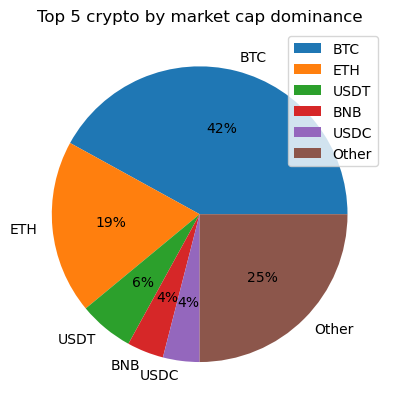

In [17]:
plt.title("Top 5 crypto by market cap dominance")
plt.pie(y, labels=z, autopct='%1.0f%%')
plt.legend()
plt.show()


Top 15 oldest crypto:

In [18]:
df_last_extr.sort_values(by='date_added')[["name","symbol", "date_added", "quote.USD.price"]].head(15)


,name,symbol,date_added,quote.USD.price
1600,Bitcoin,BTC,2013-04-28,23906.499740
1613,Litecoin,LTC,2013-04-28,94.170347
1605,XRP,XRP,2013-08-04,0.388808
1609,Dogecoin,DOGE,2013-12-15,0.084519
1770,DigiByte,DGB,2014-02-06,0.012280
1666,Dash,DASH,2014-02-14,70.948530
1944,WhiteCoin,XWC,2014-04-18,0.095789
1973,MaidSafeCoin,MAID,2014-04-28,0.139695
1626,Monero,XMR,2014-05-21,152.907918
1629,Stellar,XLM,2014-08-05,0.091163


Top 10 last 24h gainers:

In [19]:
df_gainers=df_last_extr.sort_values(by='quote.USD.percent_change_24h', ascending=False)[["name","symbol", "date_added", "quote.USD.price", "quote.USD.percent_change_24h", "quote.USD.percent_change_1h", "quote.USD.percent_change_7d", "quote.USD.percent_change_30d", "quote.USD.percent_change_60d", "quote.USD.percent_change_90d" ]].head(10)
df_gainers

,name,symbol,date_added,quote.USD.price,quote.USD.percent_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d
1970,Shiba Predator,QOM,2022-03-18,1.068258e-07,43.041172,5.837244,77.526867,302.549186,547.403845,577.431273
1732,Amp,AMP,2020-09-08,7.374275e-03,40.000215,3.592614,53.194680,49.903320,133.106648,110.956610
1968,IRISnet,IRIS,2019-04-18,4.448332e-02,31.929006,3.078462,94.475586,156.357109,246.898883,224.323230
1703,BinaryX (old),BNX,2021-05-18,1.364425e+02,30.434545,0.409959,-19.037949,56.917802,95.574778,-15.119151
1954,SelfKey,KEY,2018-01-15,1.313762e-02,29.175379,2.187174,166.203263,246.782622,375.911574,273.763197
1799,DeXe,DEXE,2020-10-07,3.751703e+00,24.565447,-2.279634,27.780092,41.060437,60.387747,55.770748
1861,Dejitaru Tsuka,TSUKA,2022-06-28,1.159512e-01,22.867590,0.436342,-17.427638,66.064856,95.248714,-1.991841
1975,Bitcicoin,BITCI,2021-01-29,8.092394e-03,21.045392,0.576527,68.399886,113.545226,258.938108,136.865203
1750,Nervos Network,CKB,2019-11-19,6.264505e-03,18.883581,1.304032,37.343098,64.161869,175.408040,148.441562
1674,Optimism,OP,2022-05-31,2.918345e+00,17.867774,-0.299124,0.298796,32.697147,219.405548,213.269869


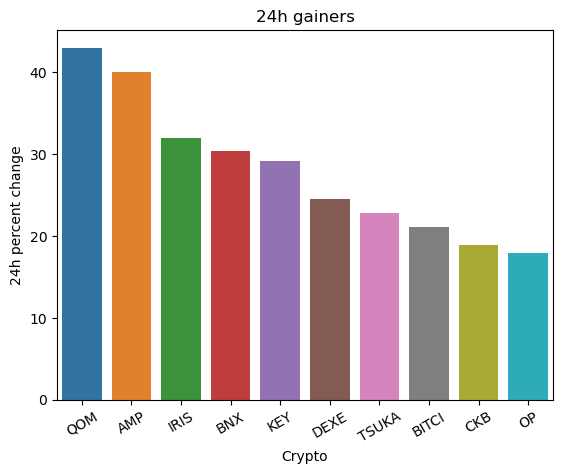

In [20]:
ax=sns.barplot(data=df_gainers, x="symbol", y="quote.USD.percent_change_24h")
ax.set(xlabel='Crypto', ylabel='24h percent change')
ax.set_title("24h gainers")
plt.xticks(rotation=30)
plt.show()


Top 10 last 24h losers:

In [21]:
df_losers=df_last_extr.sort_values(by='quote.USD.percent_change_24h')[["name","symbol", "date_added", "quote.USD.price", "quote.USD.percent_change_24h", "quote.USD.percent_change_1h", "quote.USD.percent_change_7d", "quote.USD.percent_change_30d", "quote.USD.percent_change_60d", "quote.USD.percent_change_90d" ]].head(10)
df_losers

,name,symbol,date_added,quote.USD.price,quote.USD.percent_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d
1805,T-mac DAO,TMG,2022-11-04,1.121110,-7.111646,-0.001384,-11.065985,231.743810,352.272970,356.692031
1897,Function X,FX,2019-04-25,0.233411,-5.626687,-1.680803,12.509923,18.250665,34.548797,37.073900
1981,Dawn Protocol,DAWN,2020-05-27,0.823346,-4.497438,-0.678984,1.034149,10.046375,38.107176,44.095563
1891,Neutrino Index,XTN,2020-01-30,0.146706,-4.337207,-0.054863,-23.788675,-57.228840,-72.981467,-84.416204
1745,Onyxcoin,XCN,2022-03-09,0.011242,-3.612138,-0.267813,-31.795098,-4.716193,-31.398003,-72.568235
1986,Telos,TLOS,2019-09-17,0.223136,-3.551254,-0.601817,15.715525,56.252987,72.458375,26.256136
1656,Neo,NEO,2016-09-08,12.934346,-3.307729,-0.788363,36.945610,57.654809,107.435652,88.034399
1965,Wrapped NXM,WNXM,2020-07-28,22.749678,-3.182798,-0.366843,10.672978,37.786996,168.708609,119.778779
1705,BinaryX,BNX,2021-05-18,1.359037,-3.079455,0.293584,-3.079455,-3.079455,-3.079455,-3.079455
1837,Voyager Token,VGX,2017-07-18,0.486673,-2.976149,-0.586670,-15.893026,17.796163,52.376519,13.448968


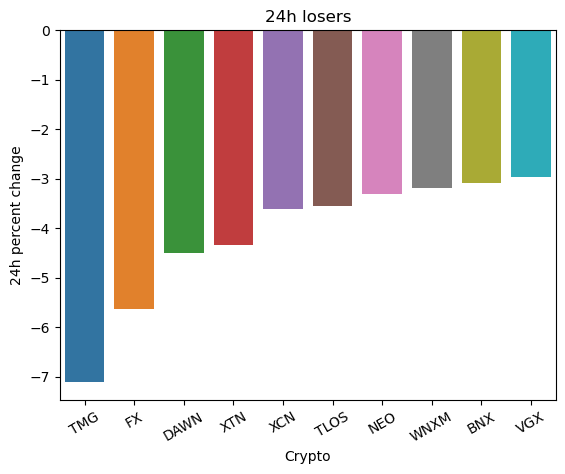

In [22]:
ax=sns.barplot(data=df_losers, x="symbol", y="quote.USD.percent_change_24h")
ax.set(xlabel='Crypto', ylabel='24h percent change')
ax.set_title("24h losers")
plt.xticks(rotation=30)
plt.show()

Now we can extract the top 10 crypto in order to analyze their market

In [23]:
df_top10=df_last_extr.sort_values(by='quote.USD.market_cap_dominance', ascending=False).head(10)
df_top10

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,timestamp
1600,1,Bitcoin,BTC,bitcoin,9989,2013-04-28,"['mineable', 'pow', 'sha-256', 'store-of-value...",2.100000e+07,1.929988e+07,1.929988e+07,NaN,1,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,23906.499740,3.098458e+10,1.5592,-0.353210,0.779230,-3.944550,4.387160,42.195965,44.694247,4.613925e+11,42.1948,5.020365e+11,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1601,1027,Ethereum,ETH,ethereum,6496,2015-08-07,"['pos', 'smart-contracts', 'ethereum-ecosystem...",NaN,1.223739e+08,1.223739e+08,NaN,2,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,1653.094766,9.468341e+09,7.7620,-0.269281,2.651850,-3.714540,2.159197,36.412390,38.560043,2.022956e+11,18.5023,2.022956e+11,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1602,825,Tether,USDT,tether,48170,2015-02-25,"['payments', 'stablecoin', 'asset-backed-stabl...",NaN,7.059060e+10,7.314177e+10,NaN,3,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,1.000122,4.232340e+10,-3.6897,-0.002726,-0.003203,-0.007754,0.001383,0.020734,0.059079,7.059920e+10,6.4572,7.315068e+10,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2023-02-23 17:50:59.559045
1603,1839,BNB,BNB,bnb,1195,2017-07-25,"['marketplace', 'centralized-exchange', 'payme...",NaN,1.578965e+08,1.599800e+08,NaN,4,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,308.577913,4.702523e+08,-15.3603,-0.329072,1.250714,-4.293285,-1.895752,26.810411,2.304878,4.872337e+10,4.4558,4.936628e+10,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1604,3408,USD Coin,USDC,usd-coin,10293,2018-10-08,"['medium-of-exchange', 'stablecoin', 'asset-ba...",NaN,4.225271e+10,4.225271e+10,NaN,5,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,0.999937,4.225057e+09,-4.0436,0.001962,-0.001484,-0.010487,0.008693,-0.025499,-0.010259,4.225007e+10,3.8640,4.225007e+10,NaN,2023-02-23T16:48:00.000Z,1027.0,Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2023-02-23 17:50:59.559045
1605,52,XRP,XRP,xrp,890,2013-08-04,"['medium-of-exchange', 'enterprise-solutions',...",1.000000e+11,5.095091e+10,9.998911e+10,NaN,6,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,0.388808,9.640379e+08,-9.6365,-0.459325,0.100521,-2.854483,-7.626843,12.366299,-4.619815,1.981014e+10,1.8117,3.888083e+10,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1606,2010,Cardano,ADA,cardano,658,2017-10-01,"['dpos', 'pos', 'platform', 'research', 'smart...",4.500000e+10,3.465542e+10,3.550287e+10,NaN,7,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,0.383830,3.123962e+08,-20.8171,-0.801998,0.822557,-6.133515,1.957608,49.456451,22.005422,1.330179e+10,1.2161,1.727235e+10,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1607,3890,Polygon,MATIC,polygon,592,2019-04-28,"['platform', 'enterprise-solutions', 'zero-kno...",1.000000e+10,8.734317e+09,1.000000e+10,NaN,8,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,1.352815,6.276990e+08,-6.8884,-0.996810,0.697108,-4.584097,34.618704,70.814737,60.744773,1.181592e+10,1.0806,1.352815e+10,NaN,2023-02-23T16:48:00.000Z,NaN,NaN,NaN,NaN,NaN,2023-02-23 17:50:59.559045
1608,4687,Binance USD,BUSD,binance-usd,6276,2019-09-20,"['stablecoin', 'asset-backed-stablecoin', 'bin...",NaN,1.178659e+10,1.178659e+10,NaN,9,NaN,NaN,NaN,2023-02-23T16:48:00.000Z,1.000114,8.604929e+09,-2.3474,0.016938,-0.028689,0.012298,0.024481,-0.000050,-0.033044,1.178794

Extraction of the date from the column last_updated that's a datatime in order to have a better visualization (we have daily data)

In [24]:
df['last_updated']=df['last_updated'].str[:10]

In [25]:
df['last_updated']

0       2023-02-18
1       2023-02-18
2       2023-02-18
3       2023-02-18
4       2023-02-18
           ...    
1995    2023-02-23
1996    2023-02-23
1997    2023-02-23
1998    2023-02-23
1999    2023-02-23
Name: last_updated, Length: 2000, dtype: object

In [26]:
top10=df_top10["symbol"].unique()
top10

array(['BTC', 'ETH', 'USDT', 'BNB', 'USDC', 'XRP', 'ADA', 'MATIC', 'BUSD',
       'DOGE'], dtype=object)

Now we can plot the market graph of the first 4 crypto excluding the stablecoin (USDT, USDC):

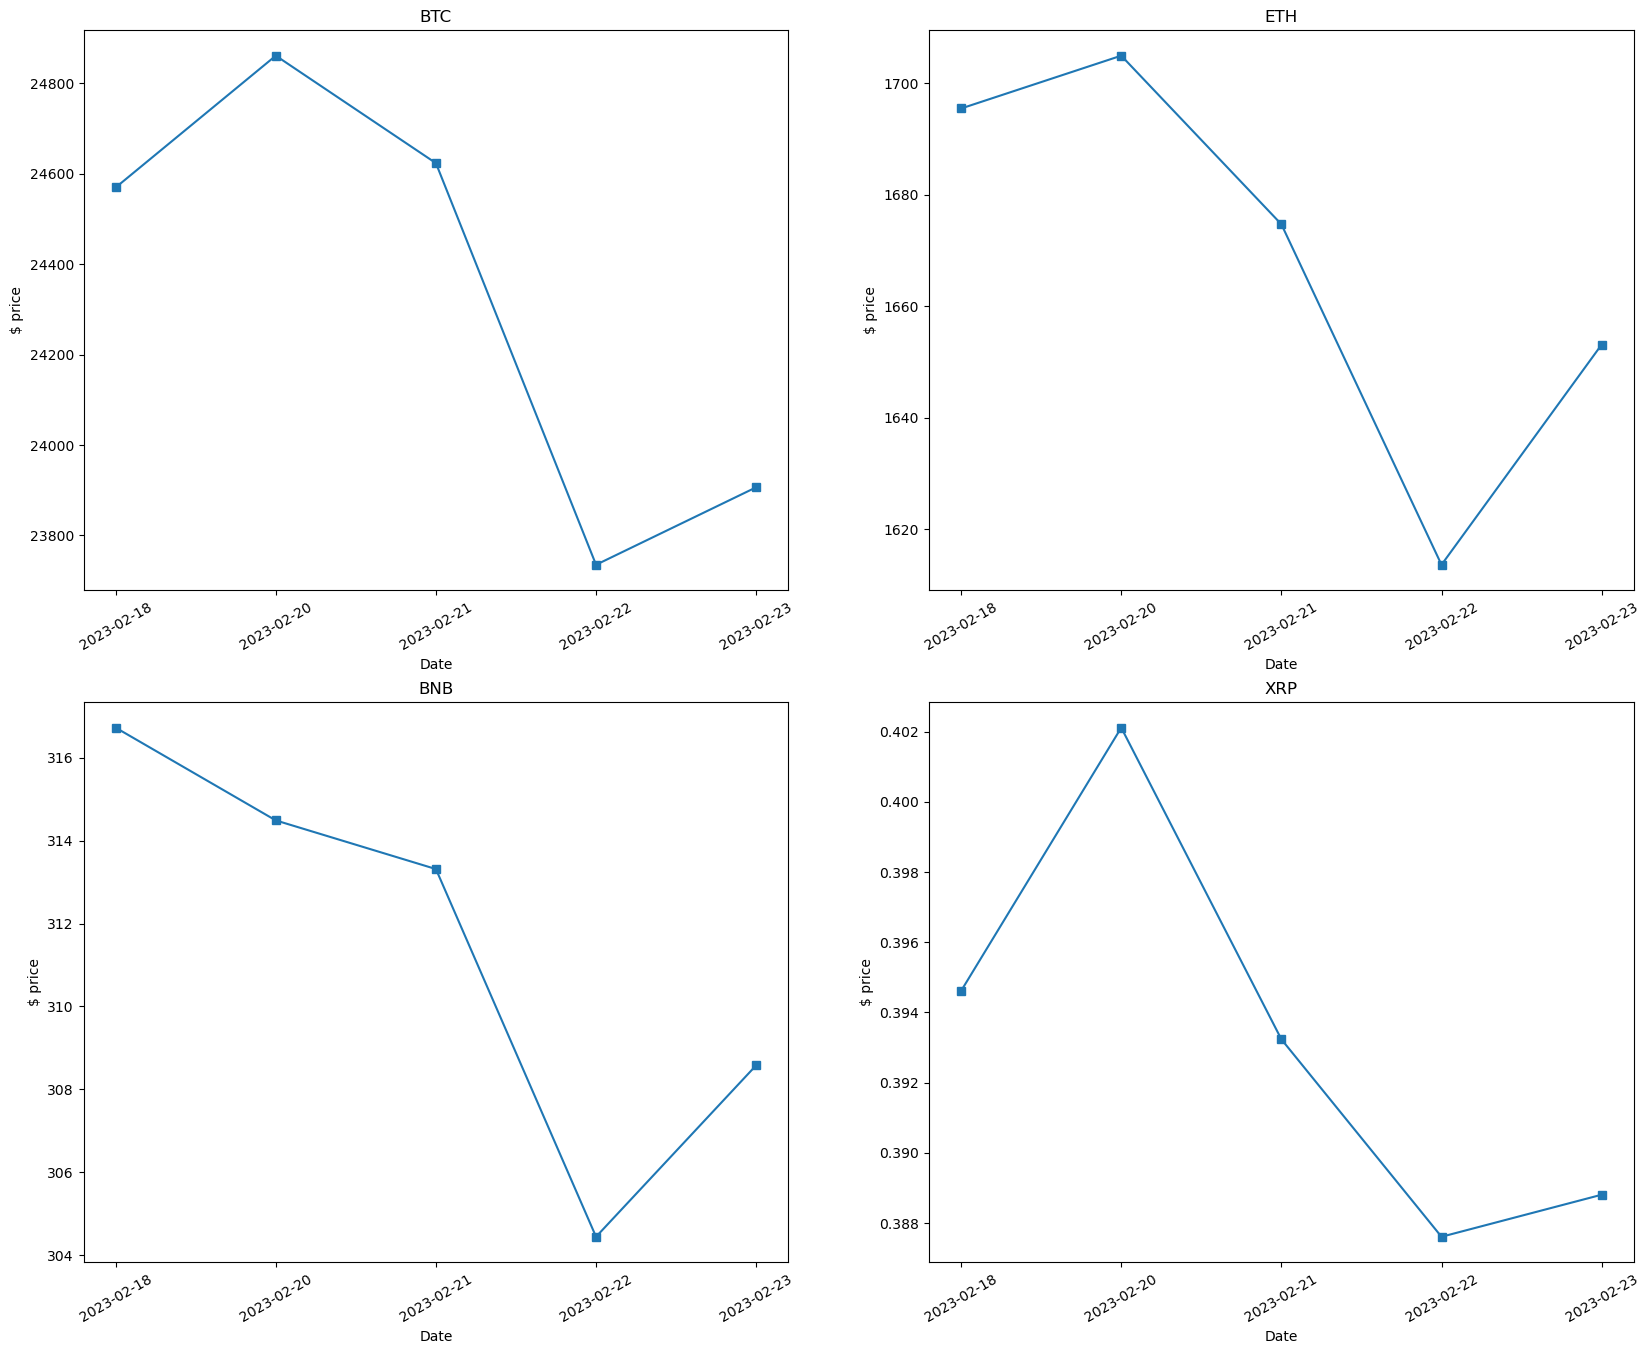

In [27]:
fig, axes= plt.subplots(figsize=(20, 16), nrows=2, ncols=2)
plt.xticks(rotation=30)
axes[0,0].plot(df[df["symbol"]=="BTC"]["last_updated"],df[df["symbol"]=="BTC"]["quote.USD.price"], marker="s")
axes[0,0].set_title("BTC")
axes[0,0].set_ylabel("$ price")
axes[0,0].set_xlabel("Date")
axes[0,0].tick_params(axis = 'x', rotation=30)
axes[0,1].plot(df[df["symbol"]=="ETH"]["last_updated"],df[df["symbol"]=="ETH"]["quote.USD.price"], marker="s")
axes[0,1].set_title("ETH")
axes[0,1].set_ylabel("$ price")
axes[0,1].set_xlabel("Date")
axes[0,1].tick_params(axis = 'x', rotation=30)
axes[1,0].plot(df[df["symbol"]=="BNB"]["last_updated"],df[df["symbol"]=="BNB"]["quote.USD.price"], marker="s")
axes[1,0].set_title("BNB")
axes[1,0].set_ylabel("$ price")
axes[1,0].set_xlabel("Date")
axes[1,0].tick_params(axis = 'x', rotation=30)
axes[1,1].plot(df[df["symbol"]=="XRP"]["last_updated"],df[df["symbol"]=="XRP"]["quote.USD.price"], marker="s")
axes[1,1].set_title("XRP")
axes[1,1].set_ylabel("$ price")
axes[1,1].set_xlabel("Date")
axes[1,1].tick_params(axis = 'x', rotation=30)


plt.show()

Every crypto show almost the same behavior of Bitcoin. In fact in the crypto market the trend of the coins usually follow the trend of Bitcoin. So let's see this behavior using the percent change information stored in the dataframe (1,7,40,60,90 days)

In [28]:
df_top10=df_top10[["name","quote.USD.percent_change_24h","quote.USD.percent_change_7d","quote.USD.percent_change_30d","quote.USD.percent_change_60d", "quote.USD.percent_change_90d"]]

In [29]:
df_top10=df_top10.melt(id_vars="name", var_name="period", value_name="percent change")
df_top10

,name,period,percent change
0,Bitcoin,quote.USD.percent_change_24h,0.779230
1,Ethereum,quote.USD.percent_change_24h,2.651850
2,Tether,quote.USD.percent_change_24h,-0.003203
3,BNB,quote.USD.percent_change_24h,1.250714
4,USD Coin,quote.USD.percent_change_24h,-0.001484
...,...,...,...
45,XRP,quote.USD.percent_change_90d,-4.619815
46,Cardano,quote.USD.percent_change_90d,22.005422
47,Polygon,quote.USD.percent_change_90d,60.744773
48,Binance USD,quote.USD.percent_change_90d,-0.033044


In order to have a better plot visualization we can clean the period column removing the string "quote.USD.percent_change_" with the replace method

In [30]:
df_top10["period"].replace("quote.USD.percent_change_24h", "1d", regex=True, inplace=True)
df_top10["period"].replace("quote.USD.percent_change_", "", regex=True, inplace=True)


To focus on the percent difference between with today we'll change the sign of the number (so a 10% increment from 90 days ago becames -10% than today) so we can see the trend. We'll use the percentage to have the same scale for every crypto. With absolute values the plot would have been impossible to understand with all the crypto inseide because they have too different values.

In [31]:
df_top10["percent change"]=df_top10["percent change"]*-1

We can now plot the plot:

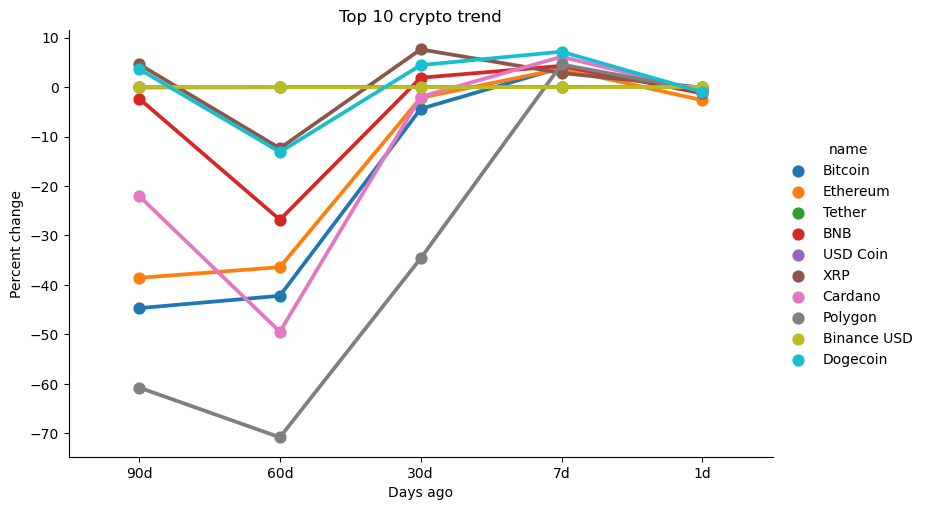

In [32]:
ax=sns.catplot(data=df_top10, x="period", y="percent change", hue="name", kind="point", height=5, aspect=1.6)
ax.set(xlabel='Days ago', ylabel='Percent change', title="Top 10 crypto trend")
#reverse axis to see the trend from past to now
plt.xlim(reversed(plt.xlim()))
plt.show()



The plot represent the percent change between today and X 90/60/30/7/1 days ago. So this represents a good approximation of the crypto trend in the last 90 days. We can notice that stable coin (Binance USD, Tether and UDS Coin) have always the same values because they represent the USD itself. Furthermore it also can be seen that the majority of the coin have a similar behavior in the same amount of time. 
Crypto market, in fact, is stricty related to Bitcoin behavior so, if bitcoin grows the market usually grow and if it drops the market drop.